In [4]:
from __future__ import annotations
import argparse
import math
import re
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gift_eval.evaluate import construct_evaluation_data
from gift_eval.tabpfn_ts_wrapper import TabPFNTSPredictor, TabPFNMode


In [ ]:
def print_seasonal_length(dataset_name):
    

In [122]:
# ---- knobs ----
dataset_name = "M_DENSE/D"
dataset_storage_path = Path("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/data/")  # change if needed
context_length = 500
batch_size = 1024
random.seed(0)

In [123]:
[(sub_dataset, ds_meta)] = construct_evaluation_data(
    dataset_name=dataset_name,
    dataset_storage_path=dataset_storage_path,
    terms=["medium"],
)

ValueError: not enough values to unpack (expected 1, got 0)

In [117]:
ds_meta

{'full_name': 'bizitobs_l2c/H/medium',
 'key': 'bizitobs_l2c',
 'freq': 'H',
 'term': 'medium',
 'season_length': 24}

In [105]:
sub_dataset.prediction_length

60

In [ ]:
list_of_datasets = 

In [130]:
dataset_terms = [
    ("bitbrains_fast_storage/H", "short"),
    ("bitbrains_rnd/H", "short"),
    ("bizitobs_l2c/H", "short"),
    ("bizitobs_l2c/H", "medium"),
    ("bizitobs_l2c/H", "long"),
    ("bizitobs_service", "short"),
    ("bizitobs_service", "medium"),
    ("bizitobs_service", "long"),
    ("hierarchical_sales/D", "short"),
    ("hierarchical_sales/W", "short"),
    ("LOOP_SEATTLE/D", "short"),
    ("M_DENSE/D", "short"),
    ("M_DENSE/H", "short"),
    ("M_DENSE/H", "medium"),
    ("M_DENSE/H", "long"),
    ("SZ_TAXI/15T", "short"),
    ("SZ_TAXI/15T", "medium"),
    ("SZ_TAXI/15T", "long"),
    ("SZ_TAXI/H", "short"),
    ("bizitobs_application", "short"),
    ("bizitobs_application", "medium"),
    ("bizitobs_application", "long"),
]

In [132]:
for (dataset_name, term) in dataset_terms:
    # print(dataset_name, term)
    [(sub_dataset, ds_meta)] = construct_evaluation_data(
        dataset_name=dataset_name,
        dataset_storage_path=dataset_storage_path,
        terms=[term],)

    print(dataset_name, term, "prediction length", sub_dataset.prediction_length, "season_length", ds_meta['season_length'])

bitbrains_fast_storage/H short prediction length 48 season_length 24
bitbrains_rnd/H short prediction length 48 season_length 24
bizitobs_l2c/H short prediction length 48 season_length 24
bizitobs_l2c/H medium prediction length 480 season_length 24
bizitobs_l2c/H long prediction length 720 season_length 24
bizitobs_service short prediction length 60 season_length 360
bizitobs_service medium prediction length 600 season_length 360
bizitobs_service long prediction length 900 season_length 360
hierarchical_sales/D short prediction length 30 season_length 1
hierarchical_sales/W short prediction length 8 season_length 1
LOOP_SEATTLE/D short prediction length 30 season_length 1
M_DENSE/D short prediction length 30 season_length 1
M_DENSE/H short prediction length 48 season_length 24
M_DENSE/H medium prediction length 480 season_length 24
M_DENSE/H long prediction length 720 season_length 24
SZ_TAXI/15T short prediction length 48 season_length 96
SZ_TAXI/15T medium prediction length 480 seaso

In [68]:
900 / 15

60.0

In [7]:
sub_dataset

In [18]:
len(sub_dataset.training_dataset)

156

In [25]:
sub_dataset.training_dataset

TrainingDataset(dataset=Map(fn=Compose(<gluonts.dataset.common.ProcessDataEntry object at 0x7fc574946310>, <function itemize_start at 0x7fc71ba29a80>), iterable=Dataset({
    features: ['item_id', 'start', 'freq', 'target'],
    num_rows: 156
})), splitter=OffsetSplitter(offset=-1440))

In [15]:
pred_len = sub_dataset.prediction_length
ds_freq  = sub_dataset.freq

In [16]:
pred_len

720

In [10]:
ds_freq

'15T'

In [12]:
from gift_eval.data import Dataset

import os
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
# load_dotenv()

# Get the GIFT_EVAL path from environment variables
gift_eval_path = os.getenv("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval")

if gift_eval_path:
    # Convert to Path object for easier manipulation
    gift_eval_path = Path(gift_eval_path)

    # Get all subdirectories (dataset names) in the GIFT_EVAL path
    dataset_names = []
    for dataset_dir in gift_eval_path.iterdir():
        if dataset_dir.name.startswith("."):
            continue
        if dataset_dir.is_dir():
            freq_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
            if freq_dirs:
                for freq_dir in freq_dirs:
                    dataset_names.append(f"{dataset_dir.name}/{freq_dir.name}")
            else:
                dataset_names.append(dataset_dir.name)

    print("Available datasets in GIFT_EVAL:")
    for name in sorted(dataset_names):
        print(f"- {name}")
else:
    print(
        "GIFT_EVAL path not found in environment variables. Please check your .env file."
    )

GIFT_EVAL path not found in environment variables. Please check your .env file.


# Retrieval of random chunks

In [26]:
import pandas as pd
import numpy as np
from typing import Iterable, List, Optional, Literal

def retrieve_training_chunks(
    df: pd.DataFrame,
    *,
    train_cutoff_ts: pd.Timestamp,
    season_length: int,
    prediction_length: int,
    freq: str,
    item_id_col: str = "item_id",
    time_col: str = "timestamp",
    target_col: str = "target",
    k: Optional[int] = None,
    sample_scope: Literal["global", "per_item"] = "global",
    random_state: Optional[int] = None,
) -> List[dict]:
    """
    Retrieve chunks from the training set (<= train_cutoff_ts).
    Each chunk has `season_length` rows and is followed by `prediction_length`
    future timestamps (with target=NaN). We only return chunks whose
    (last_chunk_timestamp + prediction_length*freq) <= train_cutoff_ts.

    Returns a list of dicts, each with:
      - 'item_id'
      - 'start_timestamp'
      - 'chunk_df' : DataFrame with columns [item_id, timestamp, target, is_future]

    Parameters
    ----------
    df : long dataframe with columns [item_id, timestamp, target]
    train_cutoff_ts : last timestamp included in the *training* region
    season_length : context size to retrieve
    prediction_length : number of future timestamps to append (as holes/NaNs)
    freq : pandas offset alias (e.g. "H", "D", "15T", "M")
    k : if provided, sample this many chunks (globally or per-item); otherwise return all
    sample_scope : "global" or "per_item" (only used when k is not None)
    random_state : optional seed for reproducibility
    """
    rng = np.random.default_rng(random_state)
    off = pd.tseries.frequencies.to_offset(freq)

    # Keep only training region
    df_train = df[df[time_col] <= train_cutoff_ts].copy()
    if df_train.empty:
        return []

    # Latest allowable *end* of the context (season) so that appended horizon stays ≤ cutoff
    # end_ctx_ts <= train_cutoff_ts - prediction_length*freq
    latest_allowed_ctx_end = train_cutoff_ts - prediction_length * off
    # Therefore valid starts must satisfy:
    # start_ts <= latest_allowed_ctx_end - (season_length-1)*off
    latest_allowed_start = latest_allowed_ctx_end - (season_length - 1) * off

    out_chunks: List[dict] = []

    # Process per item_id
    for iid, g in df_train.groupby(item_id_col, sort=False):
        g = g.sort_values(time_col).reset_index(drop=True)

        # Candidate start indices: timestamps <= latest_allowed_start
        valid_mask = g[time_col] <= latest_allowed_start
        if not valid_mask.any():
            continue

        # We also need contiguous strides of length season_length in *time*, respecting freq.
        # To be robust to any missing timestamps, we find indices where the window is strictly regular.
        idxs = np.nonzero(valid_mask.values)[0]
        # Slide within those candidate indices
        for s in idxs:
            e = s + season_length - 1
            if e >= len(g):
                break
            # Check regularity of the season window
            win_ts = g.loc[s:e, time_col]
            expected = pd.date_range(win_ts.iloc[0], periods=season_length, freq=freq)
            if not win_ts.reset_index(drop=True).equals(expected.to_series().reset_index(drop=True)):
                continue  # skip non-regular window

            end_ctx_ts = win_ts.iloc[-1]
            # Build future horizon timestamps (still within training cutoff by construction)
            fut_idx = pd.date_range(end_ctx_ts + off, periods=prediction_length, freq=freq)
            # Guard (should hold by start constraint, but be safe)
            if fut_idx[-1] > train_cutoff_ts:
                continue

            # Assemble chunk dataframe: season (observed) + horizon (NaNs)
            ctx_df = g.loc[s:e, [item_id_col, time_col, target_col]].copy()
            ctx_df["is_future"] = False

            fut_df = pd.DataFrame({
                item_id_col: iid,
                time_col: fut_idx,
                target_col: np.nan,
                "is_future": True,
            })

            chunk_df = pd.concat([ctx_df, fut_df], ignore_index=True)
            out_chunks.append({
                "item_id": iid,
                "start_timestamp": win_ts.iloc[0],
                "chunk_df": chunk_df,
            })

    # Sampling logic
    if k is not None and len(out_chunks) > k:
        if sample_scope == "global":
            out_chunks = list(rng.choice(out_chunks, size=k, replace=False))
        else:  # per_item
            per_item = {}
            for ch in out_chunks:
                per_item.setdefault(ch["item_id"], []).append(ch)
            sampled = []
            for iid, lst in per_item.items():
                kk = min(k, len(lst))
                sampled.extend(list(rng.choice(lst, size=kk, replace=False)))
            out_chunks = sampled

    return out_chunks


In [27]:
# Example toy data
ts = pd.date_range("2020-01-01", periods=100, freq="D")
toy = pd.DataFrame({
    "item_id": ["A"] * 100,
    "timestamp": ts,
    "target": np.arange(100, dtype=float),
})

# Define training cutoff (e.g., first evaluated window starts at 2020-04-20)
train_cutoff = pd.Timestamp("2020-04-19")  # last day included in training

chunks = retrieve_training_chunks(
    toy,
    train_cutoff_ts=train_cutoff,
    season_length=7,
    prediction_length=14,
    freq="D",
    k=5,                     # sample 5 chunks (optional)
    sample_scope="global",
    random_state=42,
)

# Peek at the first chunk
chunks[0]["chunk_df"].head(12)


,item_id,timestamp,target,is_future
0,A,2020-03-08,67.0,False
1,A,2020-03-09,68.0,False
2,A,2020-03-10,69.0,False
3,A,2020-03-11,70.0,False
4,A,2020-03-12,71.0,False
5,A,2020-03-13,72.0,False
6,A,2020-03-14,73.0,False
7,A,2020-03-15,NaN,True
8,A,2020-03-16,NaN,True
9,A,2020-03-17,NaN,True


In [40]:
import numpy as np
import pandas as pd

def chunks_from_gifteval_training(
    sub_dataset,                     # gift_eval.data.Dataset
    season_length: int,
    prediction_length: int | None = None,
    k: int = 10,
    sample_scope: str = "global",    # "global" (fill across all series) or "per_item"
    random_state: int | None = None,
    include_past_feat: bool = False,
):
    """
    Sample chunks of length `season_length` from the training split (strictly before the first
    evaluated window), and *append* `prediction_length` timestamps that still fall before the training cutoff.
    Returns a list of dicts with chunk DataFrames + metadata.

    Training cutoff is taken as the *last timestamp of the first test context window* (gift-eval’s split).
    """
    rng = np.random.default_rng(random_state)

    # default horizon from the sub_dataset
    if prediction_length is None:
        prediction_length = int(sub_dataset.prediction_length)

    # gift-eval test_data: (context_dict, forecast_dict)
    # we use the *context* as the full training history up to the cutoff
    test_ctx, _ = sub_dataset.test_data

    # Extract per-item arrays
    starts = test_ctx["start"]              # array-like of start timestamps (Period or str)
    freqs  = test_ctx["freq"]               # array-like of freq strings
    targets = test_ctx["target"]            # shape: [num_items, T_ctx]
    item_ids = test_ctx.get("item_id", np.arange(len(targets)))

    # Optional aligned past features
    pfeat = test_ctx.get("past_feat_dynamic_real", None) if include_past_feat else None

    # Build a table of valid (item, start_idx) candidates
    candidates = []
    for i in range(len(targets)):
        y = targets[i]
        T = int(len(y))
        max_start = T - (season_length + prediction_length)
        if max_start >= 0:
            # item i can provide starts in [0, max_start]
            candidates.append((i, max_start))

    if not candidates:
        raise ValueError(
            "No series has enough training history to take "
            f"{season_length}+{prediction_length} points before the cutoff."
        )

    # Helper to build a timestamp index from (start, freq, length)
    def build_index(start_val, freq_str, length):
        if isinstance(start_val, pd.Period):
            start_period = start_val
        else:
            # gift-eval frequently stores start as string; normalize via Period
            start_period = pd.Period(start_val, freq=freq_str)
        # PeriodIndex is robust for irregular anchors; convert to Timestamp if you prefer
        idx = pd.period_range(start=start_period, periods=length, freq=freq_str).to_timestamp()
        return idx

    chunks = []

    if sample_scope == "global":
        # Flatten all eligible (item, possible_starts) and sample k of them
        flat = []
        for i, max_start in candidates:
            if max_start >= 0:
                # we don't enumerate all starts (could be huge); sample proportional
                # but keep enough so that global k can be satisfied robustly
                # upper bound of starts to expose (heuristic): up to 5*k split across items
                budget = max(1, min(max_start + 1, 5 * k // max(1, len(candidates))))
                starts_i = rng.choice(np.arange(max_start + 1), size=budget, replace=(budget > (max_start + 1)))
                flat.extend((i, int(s)) for s in starts_i)
        if not flat:
            # fallback: enumerate minimally
            for i, max_start in candidates:
                flat.extend((i, int(s)) for s in range(max_start + 1))
        # sample k from flat
        pick = rng.choice(len(flat), size=min(k, len(flat)), replace=False)
        picks = [flat[j] for j in pick]
    elif sample_scope == "per_item":
        # sample up to ceil(k / num_items) per item
        per_item = max(1, int(np.ceil(k / len(candidates))))
        picks = []
        for i, max_start in candidates:
            possible = np.arange(max_start + 1)
            chosen = rng.choice(
                possible, size=min(per_item, len(possible)), replace=False
            )
            picks.extend((i, int(s)) for s in chosen)
        if len(picks) > k:
            picks = list(rng.choice(np.arange(len(picks)), size=k, replace=False))
            picks = [picks[j] if isinstance(picks[j], tuple) else picks[j] for j in picks]
    else:
        raise ValueError("sample_scope must be 'global' or 'per_item'.")

    # Construct chunk DataFrames
    for i, s0 in picks:
        y = targets[i]
        freq = freqs[i]
        start = starts[i]

        # slice [s0, s0 + season_length + prediction_length)
        L = season_length + prediction_length
        y_slice = y[s0 : s0 + L]

        # timestamps
        idx_full = build_index(start, freq, len(y))
        idx_slice = idx_full[s0 : s0 + L]

        df = pd.DataFrame(
            {
                "target": y_slice,
                "is_label": [0] * season_length + [1] * prediction_length,
            },
            index=idx_slice,
        )

        # include past features if requested (aligned slice)
        if pfeat is not None:
            # pfeat shape could be [num_items, num_feat, T]
            pf_i = pfeat[i]
            # accommodate both [num_feat, T] or [T, num_feat]
            if pf_i.ndim == 2:
                if pf_i.shape[0] < pf_i.shape[1]:   # [num_feat, T]
                    pf_s = pf_i[:, s0 : s0 + L]
                    for f_idx in range(pf_s.shape[0]):
                        df[f"past_feat_{f_idx}"] = pf_s[f_idx]
                else:                                # [T, num_feat]
                    pf_s = pf_i[s0 : s0 + L, :]
                    for f_idx in range(pf_s.shape[1]):
                        df[f"past_feat_{f_idx}"] = pf_s[:, f_idx]
            else:
                # 1D feature (rare)
                df["past_feat_0"] = pf_i[s0 : s0 + L]

        chunks.append(
            {
                "item_idx": int(i),
                "item_id": item_ids[i] if isinstance(item_ids, (list, np.ndarray)) else int(i),
                "start_offset": int(s0),
                "season_length": int(season_length),
                "prediction_length": int(prediction_length),
                "chunk_df": df,
            }
        )

    return chunks


In [41]:
from pathlib import Path
from gift_eval.data import Dataset

storage_root = Path("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/data")

ds = Dataset(
    name="M_DENSE/H",
    term="short",
    to_univariate=True,
    storage_path=storage_root,
)

chunks = chunks_from_gifteval_training(
    ds,
    season_length=12,
    prediction_length=None,   # defaults to ds.prediction_length
    k=1,
    sample_scope="global",
    random_state=123,
    include_past_feat=False,
)

print(ds.freq, ds.prediction_length, ds.windows)  # quick sanity check
print(chunks[0]["item_id"], chunks[0]["start_offset"])
print(chunks[0]["chunk_df"].head(20))


IndexError: tuple index out of range

# Max top_k analysis

Analyzing bizitobs_service...
Analyzing hierarchical_sales/D...
Analyzing hierarchical_sales/W...
Analyzing LOOP_SEATTLE/D...
Analyzing SZ_TAXI/15T...
Analyzing SZ_TAXI/H...
Analyzing M_DENSE/H...
Analyzing M_DENSE/D...
Analyzing bitbrains_fast_storage/H...
Analyzing bizitobs_application...
Analyzing bitbrains_rnd/H...
Analyzing bizitobs_l2c/H...

=== DATASET SUMMARY ===
                 dataset  term  num_series  season_len  pred_len  base_rows  max_k_per_series  base_utilization_%
          LOOP_SEATTLE/D short         646           1        30        646                14                6.46
               M_DENSE/D short          90           1        30         90               110                0.90
               M_DENSE/H short         600          24        48      14400                 0              144.00
             SZ_TAXI/15T short        1092          96        48     104832                 0             1048.32
               SZ_TAXI/H short         312          24  

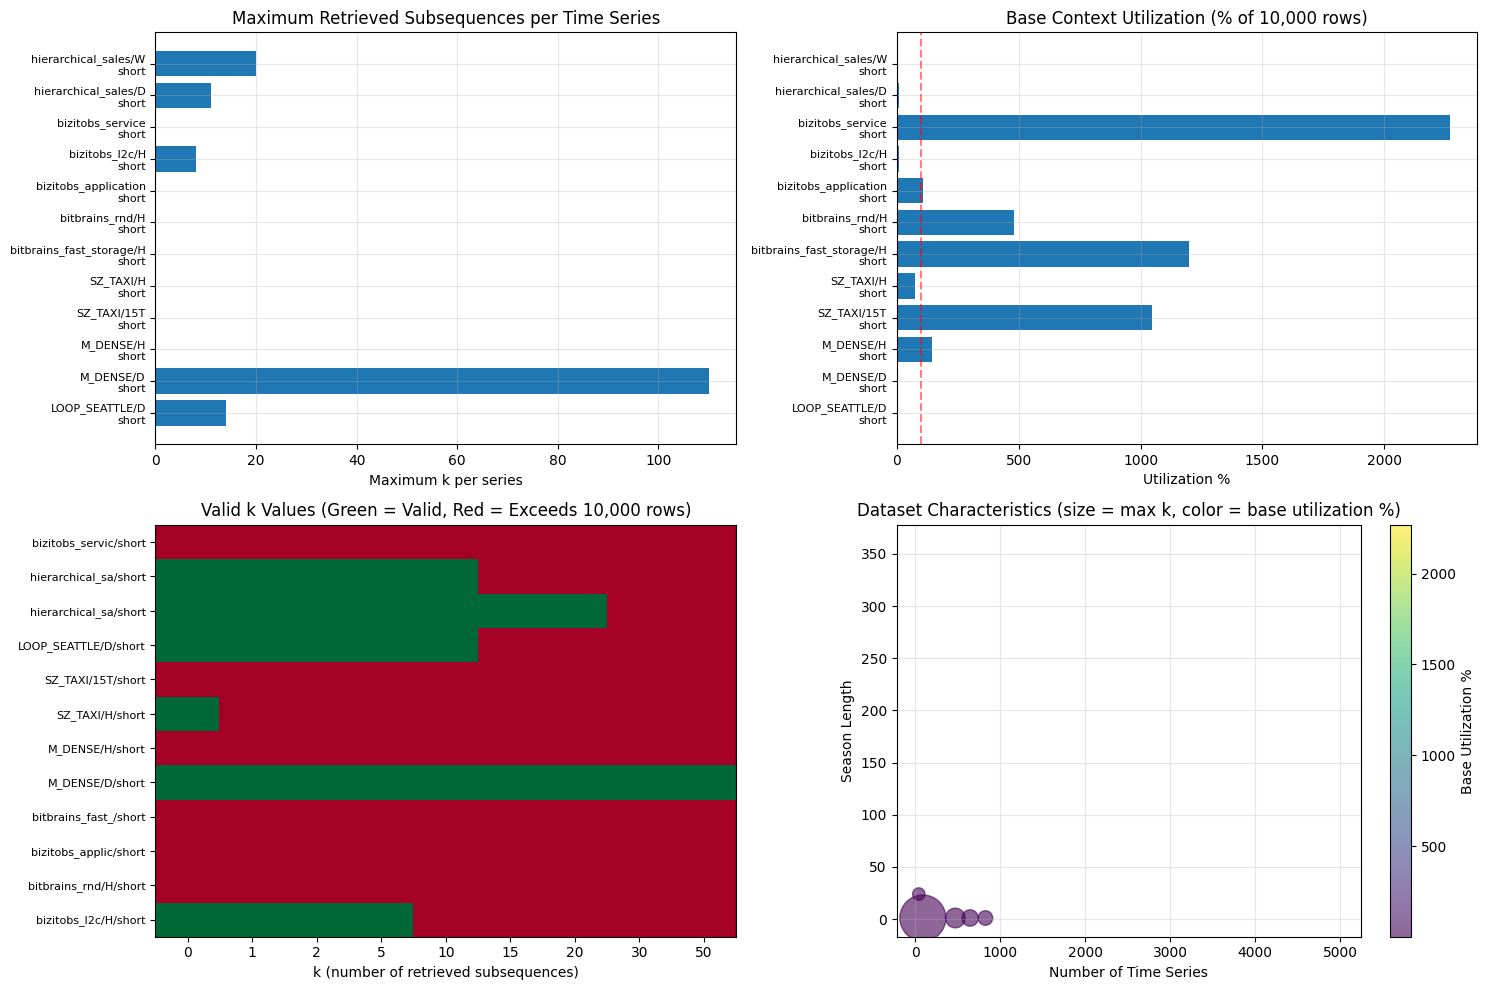


=== RECOMMENDATIONS ===

bizitobs_service (short):
  ⚠️  Base context alone uses 226,800/10,000 rows
  → No retrieval augmentation possible

hierarchical_sales/D (short):
  ✓ Good augmentation potential: max k = 11 per series
  → Recommended k values:
     k =   5 (50% utilization)
     k =   8 (75% utilization)
     k =   9 (90% utilization)

hierarchical_sales/W (short):
  ✓ Good augmentation potential: max k = 20 per series
  → Recommended k values:
     k =   9 (50% utilization)
     k =  14 (75% utilization)
     k =  18 (90% utilization)

LOOP_SEATTLE/D (short):
  ✓ Good augmentation potential: max k = 14 per series
  → Recommended k values:
     k =   6 (50% utilization)
     k =  10 (75% utilization)
     k =  12 (90% utilization)

SZ_TAXI/15T (short):
  ⚠️  Base context alone uses 104,832/10,000 rows
  → No retrieval augmentation possible

SZ_TAXI/H (short):
  ⚠️  Base context alone uses 7,488/10,000 rows
  → No retrieval augmentation possible

M_DENSE/H (short):
  ⚠️  Base c

In [43]:
# %%
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary modules
import sys


from gift_eval.data import Dataset
from gift_eval.dataset_definition import DATASET_PROPERTIES_MAP
from gluonts.time_feature import get_seasonality

# %%
# Configuration
DATASETS = [
    "bizitobs_service",
    "hierarchical_sales/D",
    "hierarchical_sales/W",
    "LOOP_SEATTLE/D",
    "SZ_TAXI/15T",
    "SZ_TAXI/H",
    "M_DENSE/H",
    "M_DENSE/D",
    "bitbrains_fast_storage/H",
    "bizitobs_application",
    "bitbrains_rnd/H",
    "bizitobs_l2c/H",
]

TERMS = ["short", "medium", "long"]
MAX_CONTEXT_ROWS = 10000
DATASET_STORAGE_PATH = Path("/home/dplaskow/pfn-gift-eval/tabpfn-time-series/gift_eval/data")  # Adjust as needed

# Number of features added per timestep (approximate)
# Based on DEFAULT_FEATURES in tabpfn_ts_wrapper.py
FEATURES_PER_TIMESTEP = 10  # Approximate: RunningIndex, Calendar features, AutoSeasonal

# %%
def analyze_dataset_context(dataset_name: str, storage_path: Path) -> List[Dict]:
    """
    Analyze context requirements for a dataset across all terms.
    """
    results = []
    
    # Parse dataset name
    if "/" in dataset_name:
        ds_key = dataset_name.split("/")[0].lower()
        ds_freq = dataset_name.split("/")[1]
    else:
        ds_key = dataset_name.lower()
        ds_freq = DATASET_PROPERTIES_MAP.get(ds_key, {}).get("frequency", "D")
    
    # Try each term
    for term in TERMS:
        try:
            # Check if this dataset has this term
            if term in ["medium", "long"] and not any(
                dataset_name in d for d in ["hierarchical_sales", "LOOP_SEATTLE", "SZ_TAXI", "M_DENSE"]
            ):
                continue
            
            # Load dataset metadata
            to_univariate = False
            try:
                dataset = Dataset(
                    name=dataset_name,
                    term=term,
                    to_univariate=False,
                    storage_path=storage_path,
                )
                if dataset.target_dim > 1:
                    to_univariate = True
            except:
                continue
            
            dataset = Dataset(
                name=dataset_name,
                term=term,
                to_univariate=to_univariate,
                storage_path=storage_path,
            )
            
            # Get key parameters
            season_length = get_seasonality(dataset.freq)
            prediction_length = dataset.prediction_length
            num_time_series = len(dataset.test_data)
            
            # Calculate base context per time series
            base_context_length = season_length  # Most recent seasonal cycle
            subsequence_length = season_length + prediction_length  # Each retrieved subsequence
            
            # Account for features (each row becomes multiple columns)
            rows_per_base_timestep = 1  # In terms of row count for TabPFN
            rows_per_subsequence = season_length * rows_per_base_timestep  # Only context part is kept
            
            # Total base context rows across all time series
            total_base_rows = base_context_length * num_time_series * rows_per_base_timestep
            
            # Calculate maximum k (number of retrieved subsequences) per time series
            remaining_budget = MAX_CONTEXT_ROWS - total_base_rows
            
            if remaining_budget > 0:
                max_k_per_series = remaining_budget // (rows_per_subsequence * num_time_series)
            else:
                max_k_per_series = 0
            
            # Calculate row counts for different k values
            k_analysis = []
            for k in [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]:
                total_rows = total_base_rows + (k * rows_per_subsequence * num_time_series)
                k_analysis.append({
                    'k': k,
                    'total_rows': total_rows,
                    'valid': total_rows <= MAX_CONTEXT_ROWS,
                    'utilization': (total_rows / MAX_CONTEXT_ROWS) * 100
                })
            
            result = {
                'dataset': dataset_name,
                'term': term,
                'freq': ds_freq,
                'num_time_series': num_time_series,
                'season_length': season_length,
                'prediction_length': prediction_length,
                'base_context_length': base_context_length,
                'subsequence_length': subsequence_length,
                'rows_per_subsequence': rows_per_subsequence,
                'total_base_rows': total_base_rows,
                'max_k_per_series': max_k_per_series,
                'max_total_k': max_k_per_series * num_time_series,
                'k_analysis': k_analysis
            }
            
            results.append(result)
            
        except Exception as e:
            print(f"Error processing {dataset_name}/{term}: {e}")
            continue
    
    return results

# %%
# Analyze all datasets
all_results = []
for dataset_name in DATASETS:
    print(f"Analyzing {dataset_name}...")
    results = analyze_dataset_context(dataset_name, DATASET_STORAGE_PATH)
    all_results.extend(results)

# %%
# Create summary DataFrame
summary_data = []
for r in all_results:
    summary_data.append({
        'dataset': r['dataset'],
        'term': r['term'],
        'num_series': r['num_time_series'],
        'season_len': r['season_length'],
        'pred_len': r['prediction_length'],
        'base_rows': r['total_base_rows'],
        'max_k_per_series': r['max_k_per_series'],
        'base_utilization_%': (r['total_base_rows'] / MAX_CONTEXT_ROWS) * 100
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['dataset', 'term'])

print("\n=== DATASET SUMMARY ===")
print(summary_df.to_string(index=False))

# %%
# Detailed k-analysis for each dataset
print("\n=== DETAILED K-ANALYSIS ===")
for r in all_results:
    print(f"\n{r['dataset']} ({r['term']})")
    print(f"  Time series: {r['num_time_series']}")
    print(f"  Season length: {r['season_length']}")
    print(f"  Prediction length: {r['prediction_length']}")
    print(f"  Base context rows: {r['total_base_rows']:,}")
    print(f"  Max k per series: {r['max_k_per_series']}")
    print("\n  k-value analysis:")
    print("  k  | Total Rows | Valid | Utilization %")
    print("  " + "-" * 40)
    for k_info in r['k_analysis']:
        valid_mark = "✓" if k_info['valid'] else "✗"
        print(f"  {k_info['k']:3d} | {k_info['total_rows']:10,d} | {valid_mark:5s} | {k_info['utilization']:6.1f}%")

# %%
# Visualize maximum k values across datasets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Max k per series for each dataset
ax = axes[0, 0]
plot_data = summary_df.copy()
plot_data['dataset_term'] = plot_data['dataset'] + '\n' + plot_data['term']
ax.barh(range(len(plot_data)), plot_data['max_k_per_series'])
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['dataset_term'], fontsize=8)
ax.set_xlabel('Maximum k per series')
ax.set_title('Maximum Retrieved Subsequences per Time Series')
ax.grid(True, alpha=0.3)

# Plot 2: Base utilization
ax = axes[0, 1]
ax.barh(range(len(plot_data)), plot_data['base_utilization_%'])
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['dataset_term'], fontsize=8)
ax.set_xlabel('Utilization %')
ax.set_title('Base Context Utilization (% of 10,000 rows)')
ax.axvline(x=100, color='r', linestyle='--', alpha=0.5, label='Max capacity')
ax.grid(True, alpha=0.3)

# Plot 3: Heatmap of valid k values
ax = axes[1, 0]
k_values = [0, 1, 2, 5, 10, 15, 20, 30, 50]
validity_matrix = []
dataset_labels = []

for r in all_results:
    dataset_labels.append(f"{r['dataset'][:15]}/{r['term']}")
    row = []
    for k in k_values:
        k_info = next((x for x in r['k_analysis'] if x['k'] == k), None)
        if k_info:
            row.append(1 if k_info['valid'] else 0)
        else:
            row.append(0)
    validity_matrix.append(row)

im = ax.imshow(validity_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xticks(range(len(k_values)))
ax.set_xticklabels(k_values)
ax.set_yticks(range(len(dataset_labels)))
ax.set_yticklabels(dataset_labels, fontsize=8)
ax.set_xlabel('k (number of retrieved subsequences)')
ax.set_title('Valid k Values (Green = Valid, Red = Exceeds 10,000 rows)')

# Plot 4: Scatter plot of dataset characteristics
ax = axes[1, 1]
ax.scatter(summary_df['num_series'], summary_df['season_len'], 
           s=summary_df['max_k_per_series']*10, 
           alpha=0.6, c=summary_df['base_utilization_%'], cmap='viridis')
ax.set_xlabel('Number of Time Series')
ax.set_ylabel('Season Length')
ax.set_title('Dataset Characteristics (size = max k, color = base utilization %)')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(ax.collections[0], ax=ax, label='Base Utilization %')

plt.tight_layout()
plt.show()

# %%
# Generate recommendations for each dataset
print("\n=== RECOMMENDATIONS ===")
for r in all_results:
    print(f"\n{r['dataset']} ({r['term']}):")
    
    if r['max_k_per_series'] == 0:
        print(f"  ⚠️  Base context alone uses {r['total_base_rows']:,}/{MAX_CONTEXT_ROWS:,} rows")
        print(f"  → No retrieval augmentation possible")
    elif r['max_k_per_series'] < 5:
        print(f"  ⚠️  Limited augmentation: max k = {r['max_k_per_series']} per series")
        print(f"  → Consider using k ∈ [1, {r['max_k_per_series']}]")
    else:
        # Find optimal k values (50%, 75%, 90% utilization)
        optimal_k = []
        for target_util in [50, 75, 90]:
            target_rows = (target_util / 100) * MAX_CONTEXT_ROWS
            k_needed = int((target_rows - r['total_base_rows']) / 
                          (r['rows_per_subsequence'] * r['num_time_series']))
            if 0 < k_needed <= r['max_k_per_series']:
                optimal_k.append((k_needed, target_util))
        
        print(f"  ✓ Good augmentation potential: max k = {r['max_k_per_series']} per series")
        if optimal_k:
            print(f"  → Recommended k values:")
            for k, util in optimal_k:
                print(f"     k = {k:3d} ({util}% utilization)")

# %%
# Export results to CSV for further analysis
summary_df.to_csv('dataset_context_analysis.csv', index=False)
print("\nResults saved to 'dataset_context_analysis.csv'")

# Create detailed k-analysis CSV
k_analysis_data = []
for r in all_results:
    for k_info in r['k_analysis']:
        k_analysis_data.append({
            'dataset': r['dataset'],
            'term': r['term'],
            'k': k_info['k'],
            'total_rows': k_info['total_rows'],
            'valid': k_info['valid'],
            'utilization_%': k_info['utilization']
        })

k_analysis_df = pd.DataFrame(k_analysis_data)
k_analysis_df.to_csv('dataset_k_analysis.csv', index=False)
print("K-analysis saved to 'dataset_k_analysis.csv'")

In [ ]:
# Max-k calculator that respects "short/medium/long" terms per your data.py multipliers.
# It infers base prediction_length from M4_PRED_LENGTH_MAP or PRED_LENGTH_MAP,
# and multiplies by 1x/10x/15x for short/medium/long respectively.

from typing import Dict, Tuple, Optional, List, Set
from collections import defaultdict
import pandas as pd
from pandas.tseries.frequencies import to_offset

# ---------- INPUTS ----------

# Your datasets list (add /short, /medium, /long wherever they exist)
DATASETS_STR = (
    # "bizitobs_service"
    # "hierarchical_sales/D"
    # "hierarchical_sales/W"
    # "LOOP_SEATTLE/D"
    # "SZ_TAXI/15T"
    # "SZ_TAXI/H"
    # "M_DENSE/H"
    # "M_DENSE/D"
    # "bitbrains_fast_storage/H"
    # "bizitobs_application"
    # "bitbrains_rnd/H"
    # "bizitobs_l2c/H"
    "bitbrains_fast_storage/H/short"
    "bitbrains_rnd/H/short"
    "bizitobs_application/10S/short"
    "bizitobs_application/10S/medium"
    "bizitobs_application/10S/long"
    "bizitobs_l2c/H/short"
    "bizitobs_l2c/H/medium"
    "bizitobs_l2c/H/long"
    "bizitobs_service/10S/short"
    "bizitobs_service/10S/medium"
    "bizitobs_service/10S/long"
    "hierarchical_sales/D/short"
    "hierarchical_sales/W/short"
    "loop_seattle/D/short"
    "m_dense/D/short"
    "m_dense/H/short"
    "m_dense/H/medium"
    "m_dense/H/long"
    "sz_taxi/15T/short"
    "sz_taxi/15T/medium"
    "sz_taxi/15T/long"
    "sz_taxi/H/short"
    # Examples that explicitly declare terms:
    # "hierarchical_sales/W/long SZ_TAXI/short/15T bizitobs_service/medium"
)

SEASONAL_LENGHTS = {
    "bitbrains_fast_storage/H/short":
}

ROW_BUDGET = 10_000

# If a variant appears without explicit term(s), which terms should we compute?
# Options: ("short",) or ("short","medium","long")
DEFAULT_TERMS_IF_MISSING: Tuple[str, ...] = ("short","medium","long")

# Seasonal length by frequency token (use the *raw* token you put in the dataset string)
SEASONALITY_BY_FREQ: Dict[str, int] = {
    "15T": 96,   # 96 samples/day at 15-min resolution
    "H":   24,   # 24 hours/day
    "D":   7,    # weekly seasonality
    "W":   52,   # annual seasonality in weeks
}
DEFAULT_FREQ_IF_UNSPECIFIED = "H"   # used for tokens with no /freq
TEST_CONTEXT_OVERRIDES: Dict[Tuple[str, Optional[str]], int] = {}
# ↑ override per (name, freq) if your initial test context != seasonal_length

# ---------- Mirrors of your data.py maps ----------

M4_PRED_LENGTH_MAP = {
    "A": 6, "Q": 8, "M": 18, "W": 13, "D": 14, "H": 48,
}
PRED_LENGTH_MAP = {
    "M": 12, "W": 8, "D": 30, "H": 48, "T": 48, "S": 60,
}
# Included for completeness, not used by your Dataset.prediction_length:
TFB_PRED_LENGTH_MAP = {
    "A": 6, "H": 48, "Q": 8, "D": 14, "M": 18, "W": 13, "U": 8, "T": 8,
}

TERM_MULTIPLIER = {"short": 1, "medium": 10, "long": 15}
TERM_TOKENS = set(TERM_MULTIPLIER.keys())

# ---------- Helpers ----------

def parse_token(tok: str):
    """Return (name, freq, term). Accepts name/freq, name/term, name/freq/term or name/term/freq."""
    parts = tok.split("/")
    name = parts[0]
    freq = None
    term = None
    for p in parts[1:]:
        pl = p.lower()
        if pl in TERM_TOKENS:
            term = pl
        else:
            freq = p
    return name, freq, term

def freq_key_for_pred(freq_token: str) -> str:
    """
    Match your data.py normalization: to_offset(freq).name.
    Example: '15T' -> 'T', 'H' -> 'H', 'D' -> 'D'.
    """
    return to_offset(freq_token).name

def seasonal_length_from_freq_token(freq_token: Optional[str]) -> int:
    if not freq_token:
        freq_token = DEFAULT_FREQ_IF_UNSPECIFIED
    return SEASONALITY_BY_FREQ.get(freq_token, 24)

def base_prediction_length(dataset_name: str, freq_token: str) -> int:
    key = freq_key_for_pred(freq_token)  # normalized like your data.py
    if "m4" in dataset_name.lower():
        mp = M4_PRED_LENGTH_MAP
    else:
        mp = PRED_LENGTH_MAP
    if key not in mp:
        raise KeyError(f"Frequency '{freq_token}' (normalized '{key}') not in prediction-length map.")
    return mp[key]

def prediction_length_with_term(dataset_name: str, freq_token: str, term: str) -> int:
    base = base_prediction_length(dataset_name, freq_token)
    return base * TERM_MULTIPLIER[term]

def test_context_len(name: str, freq: Optional[str], seasonal_len: int) -> int:
    # Override (name, freq) if provided; else default to seasonal_len.
    return TEST_CONTEXT_OVERRIDES.get((name, freq), seasonal_len)

def max_k_under_budget(subseq_len: int, test_ctx_len: int, budget: int) -> int:
    rem = budget - test_ctx_len
    if subseq_len <= 0 or rem < 0:
        return 0
    return rem // subseq_len

# ---------- Build term presence and compute max_k ----------

tokens = DATASETS_STR.split()

# Group tokens by (name, freq) and record what terms were explicitly provided
terms_present_by_variant: Dict[Tuple[str, Optional[str]], Set[str]] = defaultdict(set)
for tok in tokens:
    name, freq, term = parse_token(tok)
    if term:
        terms_present_by_variant[(name, freq)].add(term)
    else:
        # Ensure the variant key exists even if no term was specified
        _ = terms_present_by_variant[(name, freq)]

summary_rows = []
detailed_rows = []

for (name, freq) in sorted(terms_present_by_variant.keys()):
    # Determine which terms to compute for this variant
    explicit_terms = terms_present_by_variant[(name, freq)]
    if explicit_terms:
        terms_to_eval = sorted(explicit_terms, key=lambda t: ["short","medium","long"].index(t))
    else:
        terms_to_eval = list(DEFAULT_TERMS_IF_MISSING)

    # If freq missing in the token, we will still compute using DEFAULT_FREQ_IF_UNSPECIFIED
    freq_token = freq or DEFAULT_FREQ_IF_UNSPECIFIED

    seasonal_len = seasonal_length_from_freq_token(freq_token)
    tctx_len = test_context_len(name, freq, seasonal_len)

    for term in terms_to_eval:
        pred_len = prediction_length_with_term(name, freq_token, term)
        subseq_len = seasonal_len + pred_len
        k_max = max_k_under_budget(subseq_len, tctx_len, ROW_BUDGET)
        rows_at_kmax = tctx_len + k_max * subseq_len

        summary_rows.append({
            "dataset": name,
            "freq": freq or "(unspecified)",
            "term": term,
            "seasonal_length": seasonal_len,
            "prediction_length": pred_len,
            "subsequence_len": subseq_len,
            "test_context_len": tctx_len,
            "row_budget": ROW_BUDGET,
            "max_k": int(k_max),
            "rows_at_max_k": int(rows_at_kmax),
        })

        for k in range(1, k_max + 1):
            total_rows = tctx_len + k * subseq_len
            detailed_rows.append({
                "dataset": name,
                "freq": freq or "(unspecified)",
                "term": term,
                "k": int(k),
                "total_rows": int(total_rows),
                "subsequence_len": subseq_len,
                "test_context_len": tctx_len,
            })

summary_df = pd.DataFrame(summary_rows).sort_values(["dataset","freq","term"]).reset_index(drop=True)
detailed_df = pd.DataFrame(detailed_rows).sort_values(["dataset","freq","term","k"]).reset_index(drop=True)

# Pretty print (and save for downstream use)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)

print("Summary (per dataset variant × term):")
print(summary_df.rename(columns={
    "seasonal_length":"seasonal_len",
    "prediction_length":"pred_len",
    "subsequence_len":"subseq_len",
    "test_context_len":"test_ctx_len",
}).to_string(index=False))

summary_df.to_csv("rows_per_k_summary_terms.csv", index=False)
detailed_df.to_csv("rows_per_k_detailed_terms.csv", index=False)
print("\nWrote: rows_per_k_summary_terms.csv")
print("Wrote: rows_per_k_detailed_terms.csv")


Summary (per dataset variant × term):
               dataset freq  term  seasonal_len  pred_len  subseq_len  test_ctx_len  row_budget  max_k  rows_at_max_k
bitbrains_fast_storage    H short            24        48          72            24       10000    138           9960

Wrote: rows_per_k_summary_terms.csv
Wrote: rows_per_k_detailed_terms.csv


In [74]:
# Recompute max-k using exact term-aware horizons and attempting to retrieve season_length
# via gift_eval.evaluate.construct_evaluation_data when available.
#
# If unavailable or failing, we fall back to a corrected seasonality mapping:
#   10S -> 360  (per user's ds_meta)
#   15T -> 96
#   H   -> 24
#   D   -> 7
#   W   -> 52
#
# This cell also regenerates CSVs and prints a concise summary focusing on the corrected 10S datasets.

from typing import Optional, Tuple, Dict, List, Any
import sys, importlib, importlib.util
import pandas as pd

# ---------------------- Exact dataset list ----------------------
DATASETS: List[str] = [
    "bitbrains_fast_storage/H/short",
    "bitbrains_rnd/H/short",
    "bizitobs_application/10S/short",
    "bizitobs_application/10S/medium",
    "bizitobs_application/10S/long",
    "bizitobs_l2c/H/short",
    "bizitobs_l2c/H/medium",
    "bizitobs_l2c/H/long",
    "bizitobs_service/10S/short",
    "bizitobs_service/10S/medium",
    "bizitobs_service/10S/long",
    "hierarchical_sales/D/short",
    "hierarchical_sales/W/short",
    "loop_seattle/D/short",
    "m_dense/D/short",
    "m_dense/H/short",
    "m_dense/H/medium",
    "m_dense/H/long",
    "sz_taxi/15T/short",
    "sz_taxi/15T/medium",
    "sz_taxi/15T/long",
    "sz_taxi/H/short",
]

ROW_BUDGET = 10_000

# If you have datasets locally, set this to your repo's dataset storage path; else leave None for fallback.
DATASET_STORAGE_PATH: Optional[str] = None  # e.g., "/path/to/datasets"

# Base prediction-length maps from your data.py
M4_PRED_LENGTH_MAP = {"A": 6, "Q": 8, "M": 18, "W": 13, "D": 14, "H": 48}
PRED_LENGTH_MAP    = {"M": 12, "W": 8, "D": 30, "H": 48, "T": 48, "S": 60}

# Term multipliers (short=1, medium=10, long=15)
TERM_MULTIPLIER = {"short": 1, "medium": 10, "long": 15}

# Corrected fallback seasonality mapping (raw freq token -> season_length)
FALLBACK_SEASONALITY = {
    "10S": 360,   # corrected per ds_meta
    "15T": 96,
    "H":   24,
    "D":   7,
    "W":   52,
}

# Test context defaults to season_length unless overridden
TEST_CONTEXT_OVERRIDES: Dict[str, int] = {
    # e.g., "bizitobs_service/10S/short": 360
}

def normalized_freq_key(freq_token: str) -> str:
    u = freq_token.upper()
    if u.endswith("T"):
        return "T"
    if u.endswith("S"):
        return "S"
    return u

def parse_token(tok: str) -> Tuple[str, str, str]:
    parts = tok.split("/")
    if len(parts) != 3:
        raise ValueError(f"Token must be 'name/freq/term': got '{tok}'")
    name, freq_token, term = parts[0], parts[1], parts[2].lower()
    key = f"{name}/{freq_token}"
    return key, freq_token, term

def import_construct() -> Optional[Any]:
    # Try "gift_eval.evaluate" first
    try:
        return importlib.import_module("gift_eval.evaluate").construct_evaluation_data
    except Exception:
        pass
    # Try local /mnt/data/evaluate.py
    try:
        if "/mnt/data" not in sys.path:
            sys.path.append("/mnt/data")
        import evaluate
        if hasattr(evaluate, "construct_evaluation_data"):
            return evaluate.construct_evaluation_data
    except Exception:
        pass
    return None

def try_repo_season_length(construct_fn, dataset_key: str, term: str) -> Optional[int]:
    if construct_fn is None or DATASET_STORAGE_PATH is None:
        return None
    try:
        res = construct_fn(dataset_name=dataset_key, dataset_storage_path=DATASET_STORAGE_PATH, terms=[term])
        if isinstance(res, (list, tuple)) and len(res) >= 1:
            pair = res[0]
            # ds_meta may be a dict or an object with attribute access
            if isinstance(pair, (list, tuple)) and len(pair) == 2:
                ds_meta = pair[1]
                # attribute style
                if hasattr(ds_meta, "season_length"):
                    return int(getattr(ds_meta, "season_length"))
                # dict-like
                if isinstance(ds_meta, dict) and "season_length" in ds_meta:
                    return int(ds_meta["season_length"])
    except Exception as e:
        print(f"[warn] construct_evaluation_data failed for {dataset_key}/{term}: {e}")
    return None

def base_pred_len(dataset_key: str, norm_freq: str) -> int:
    if "m4" in dataset_key.lower():
        return M4_PRED_LENGTH_MAP[norm_freq]
    return PRED_LENGTH_MAP[norm_freq]

def test_ctx_len(token: str, season_length: int) -> int:
    return TEST_CONTEXT_OVERRIDES.get(token, season_length)

def max_k_under_budget(subseq_len: int, test_ctx: int, budget: int) -> int:
    rem = budget - test_ctx
    if subseq_len <= 0 or rem < 0:
        return 0
    return rem // subseq_len

construct_fn = import_construct()

summary_rows, k_rows, variant_rows = [], [], []
variant_terms = {}

for tok in DATASETS:
    key, raw_freq, term = parse_token(tok)
    norm = normalized_freq_key(raw_freq)

    # Seasonality: try repo first, else corrected fallback
    season_len = try_repo_season_length(construct_fn, key, term)
    if season_len is None:
        season_len = FALLBACK_SEASONALITY.get(raw_freq)
        if season_len is None:
            raise KeyError(f"No fallback season_length for freq '{raw_freq}' and repo call unavailable.")

    # Prediction length
    base_pred = base_pred_len(key, norm)
    pred_len = TERM_MULTIPLIER[term] * base_pred

    # subseq/test context / k
    subseq_len = season_len + pred_len
    test_ctx = test_ctx_len(tok, season_len)
    k_max = max_k_under_budget(subseq_len, test_ctx, ROW_BUDGET)

    variant_terms.setdefault(key, []).append({"term": term, "k_max": k_max, "subseq": subseq_len, "ctx": test_ctx})

    summary_rows.append({
        "dataset_key": key,
        "term": term,
        "freq_token": raw_freq,
        "norm_freq_key": norm,
        "seasonal_length": season_len,
        "base_pred_len": base_pred,
        "term_multiplier": TERM_MULTIPLIER[term],
        "prediction_length": pred_len,
        "subsequence_len": subseq_len,
        "test_context_len": test_ctx,
        "row_budget": ROW_BUDGET,
        "max_k": int(k_max),
        "rows_at_max_k": int(test_ctx + k_max * subseq_len),
        "seasonality_source": "repo" if try_repo_season_length is not None and DATASET_STORAGE_PATH is not None else "fallback",
        "token": tok,
    })

    for k in range(1, k_max + 1):
        k_rows.append({
            "dataset_key": key,
            "term": term,
            "k": int(k),
            "total_rows": int(test_ctx + k * subseq_len),
            "subsequence_len": subseq_len,
            "test_context_len": test_ctx,
            "token": tok,
        })

for key, items in sorted(variant_terms.items(), key=lambda kv: kv[0]):
    all_terms = sorted([it["term"] for it in items], key=lambda t: ["short","medium","long"].index(t))
    k_all = min(it["k_max"] for it in items) if items else 0
    info = {it["term"]: f"subseq={it['subseq']},ctx={it['ctx']}" for it in items}
    variant_rows.append({
        "dataset_key": key,
        "terms_present": ",".join(all_terms),
        "k_all_terms": int(k_all),
        **{f"info_{t}": info[t] for t in all_terms},
    })

summary_df  = pd.DataFrame(summary_rows).sort_values(["dataset_key","term"]).reset_index(drop=True)
detailed_df = pd.DataFrame(k_rows).sort_values(["dataset_key","term","k"]).reset_index(drop=True)
variant_df  = pd.DataFrame(variant_rows).sort_values(["dataset_key"]).reset_index(drop=True)


# Show the rows most impacted by the correction (10S datasets)
focus = summary_df[summary_df["freq_token"]=="10S"][
    ["dataset_key","term","freq_token","seasonal_length","prediction_length","subsequence_len","test_context_len","max_k","rows_at_max_k","seasonality_source"]
]

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

print("Corrected seasonality results for 10S datasets (using repo or fallback=360):")
print(focus.to_string(index=False))

print("\nOne-line summary per dataset_key (k that fits ALL present terms):")
print(variant_df.to_string(index=False))


Corrected seasonality results for 10S datasets (using repo or fallback=360):
             dataset_key   term freq_token  seasonal_length  prediction_length  subsequence_len  test_context_len  max_k  rows_at_max_k seasonality_source
bizitobs_application/10S   long        10S              360                900             1260               360      7           9180           fallback
bizitobs_application/10S medium        10S              360                600              960               360     10           9960           fallback
bizitobs_application/10S  short        10S              360                 60              420               360     22           9600           fallback
    bizitobs_service/10S   long        10S              360                900             1260               360      7           9180           fallback
    bizitobs_service/10S medium        10S              360                600              960               360     10           9960           fa

In [133]:
# Term-aware max-k calculator using exact dataset names + frequencies + terms provided by the user.
# It will try to recover seasonality via an optional `construct_evaluation_data` (if available);
# otherwise it falls back to a sensible frequency->seasonality mapping.
#
# Formulas:
#   normalized_freq = to key into the prediction length maps (S, T, H, D, W, M, Q, A)
#   base_pred_len = (M4_PRED_LENGTH_MAP if 'm4' in dataset name else PRED_LENGTH_MAP)[normalized_freq]
#   term_multiplier = {'short': 1, 'medium': 10, 'long': 15}
#   prediction_length = term_multiplier * base_pred_len
#   subseq_len = season_length + prediction_length
#   total_rows(k) = test_context_len + k * subseq_len
#   max_k = floor((ROW_BUDGET - test_context_len)/subseq_len)
#
# Notes:
# - test_context_len defaults to season_length, but you can override per variant.
# - If `construct_evaluation_data` is available in your environment and `DATASET_STORAGE_PATH` is set,
#   the code will call it to obtain the season_length metadata exactly as in your repo.
# - Otherwise, it will fall back to the heuristic mapping in FALLBACK_SEASONALITY_BY_FREQ_TOKEN.

from typing import Optional, Tuple, Dict, List
import importlib
import math
import pandas as pd

# ---------------------- Exact dataset list ----------------------
DATASETS: List[str] = [
    "bitbrains_fast_storage/H/short",
    "bitbrains_rnd/H/short",
    "bizitobs_application/10S/short",
    "bizitobs_application/10S/medium",
    "bizitobs_application/10S/long",
    "bizitobs_l2c/H/short",
    "bizitobs_l2c/H/medium",
    "bizitobs_l2c/H/long",
    "bizitobs_service/10S/short",
    "bizitobs_service/10S/medium",
    "bizitobs_service/10S/long",
    "hierarchical_sales/D/short",
    "hierarchical_sales/W/short",
    "loop_seattle/D/short",
    "m_dense/D/short",
    "m_dense/H/short",
    "m_dense/H/medium",
    "m_dense/H/long",
    "sz_taxi/15T/short",
    "sz_taxi/15T/medium",
    "sz_taxi/15T/long",
    "sz_taxi/H/short",
]

# ---------------------- Config ----------------------
ROW_BUDGET = 10_000
# If you want to attempt exact seasonality via your repo helper:
DATASET_STORAGE_PATH: Optional[str] = None   # e.g., "/path/to/datasets" (set this if available)

# Test-context overrides (default is season_length if not specified)
TEST_CONTEXT_OVERRIDES: Dict[str, int] = {
    # Example:
    # "bizitobs_application/10S/short": 8640,
}

# ---------------------- Maps from your data.py ----------------------
M4_PRED_LENGTH_MAP = {"A": 6, "Q": 8, "M": 18, "W": 13, "D": 14, "H": 48}
PRED_LENGTH_MAP    = {"M": 12, "W": 8, "D": 30, "H": 48, "T": 48, "S": 60}

TERM_MULTIPLIER = {"short": 1, "medium": 10, "long": 15}

# Heuristic fallback for seasonality if construct_evaluation_data is not available
# Tokens here are the raw frequency tokens from the dataset list, not the normalized keys.
FALLBACK_SEASONALITY_BY_FREQ_TOKEN = {
    "15T": 96,    # 15-minute data -> daily seasonality
    "H":   24,    # hourly -> daily
    "D":   7,     # daily -> weekly
    "W":   52,    # weekly -> yearly
    "10S": 8640,  # 10-second data -> daily (86400/10)
    # Add others if needed
}

# ---------------------- Utilities ----------------------
def parse_token(tok: str) -> Tuple[str, str, str]:
    """Return (key, freq_token, term) where key is 'name/freq' and includes the original case of freq token."""
    parts = tok.split("/")
    if len(parts) != 3:
        raise ValueError(f"Token must be 'name/freq/term': got '{tok}'")
    name, freq_token, term = parts[0], parts[1], parts[2].lower()
    key = f"{name}/{freq_token}"
    return key, freq_token, term

def normalized_freq_key(freq_token: str) -> str:
    """
    Normalize a raw freq token to the key used in pred-length maps:
    - '15T' -> 'T'
    - '10S' -> 'S'
    - 'H','D','W','M','Q','A' stay as-is.
    """
    u = freq_token.upper()
    if u.endswith("T"):
        return "T"
    if u.endswith("S"):
        return "S"
    return u

def try_import_construct() -> Optional[callable]:
    """Try to import construct_evaluation_data from a likely module (data.py or data_preparation.py)."""
    for mod_name in ("data", "data_preparation"):
        try:
            mod = importlib.import_module(mod_name)
            if hasattr(mod, "construct_evaluation_data"):
                return getattr(mod, "construct_evaluation_data")
        except Exception:
            continue
    return None

def get_season_length_via_repo(dataset_key: str, term: str) -> Optional[int]:
    """
    Attempt to call construct_evaluation_data(dataset_name=dataset_key, dataset_storage_path=..., terms=[term])
    and return ds_meta['season_length'] if available.
    """
    if DATASET_STORAGE_PATH is None:
        return None
    construct_fn = try_import_construct()
    if construct_fn is None:
        return None
    try:
        res = construct_fn(dataset_name=dataset_key, dataset_storage_path=DATASET_STORAGE_PATH, terms=[term])
        # Expect a list like [(sub_dataset, ds_meta)]
        if isinstance(res, (list, tuple)) and len(res) >= 1:
            # pick first
            pair = res[0]
            if isinstance(pair, (list, tuple)) and len(pair) == 2:
                ds_meta = pair[1]
                if isinstance(ds_meta, dict) and "season_length" in ds_meta:
                    return int(ds_meta["season_length"])
    except Exception as e:
        print(f"[warn] construct_evaluation_data failed for {dataset_key}/{term}: {e}")
    return None

def get_season_length(dataset_key: str, raw_freq_token: str, term: str) -> int:
    # 1) Try the repo function if available and path set
    sl = get_season_length_via_repo(dataset_key, term)
    if sl is not None:
        return sl
    # 2) Fallback heuristic by raw freq token
    if raw_freq_token in FALLBACK_SEASONALITY_BY_FREQ_TOKEN:
        return FALLBACK_SEASONALITY_BY_FREQ_TOKEN[raw_freq_token]
    # 3) Last resort: simple defaults by normalized key
    norm = normalized_freq_key(raw_freq_token)
    by_norm = {"S": 8640, "T": 96, "H": 24, "D": 7, "W": 52, "M": 12, "Q": 4, "A": 1}
    if norm in by_norm:
        return by_norm[norm]
    raise KeyError(f"No seasonality available for freq '{raw_freq_token}' (dataset {dataset_key}/{term})")

def base_prediction_length(dataset_key: str, norm_freq_key: str) -> int:
    # Use M4 map only if key name includes "m4"
    if "m4" in dataset_key.lower():
        mp = M4_PRED_LENGTH_MAP
    else:
        mp = PRED_LENGTH_MAP
    if norm_freq_key not in mp:
        raise KeyError(f"Normalized freq '{norm_freq_key}' not found in prediction-length map for {dataset_key}")
    return mp[norm_freq_key]

def test_context_len(token: str, season_length: int) -> int:
    # token is full "name/freq/term"
    return TEST_CONTEXT_OVERRIDES.get(token, season_length)

def max_k_under_budget(subseq_len: int, test_ctx_len: int, budget: int) -> int:
    rem = budget - test_ctx_len
    if subseq_len <= 0 or rem < 0:
        return 0
    return rem // subseq_len

# ---------------------- Compute ----------------------
summary_rows = []
detailed_rows = []
per_variant_terms = {}

for tok in DATASETS:
    key, raw_freq, term = parse_token(tok)           # key: "name/freq"
    norm = normalized_freq_key(raw_freq)             # map to PRED_LENGTH_MAP key

    season_len = get_season_length(key, raw_freq, term)
    test_ctx   = test_context_len(tok, season_len)

    base_pred  = base_prediction_length(key, norm)
    pred_len   = TERM_MULTIPLIER[term] * base_pred
    subseq_len = season_len + pred_len
    k_max      = max_k_under_budget(subseq_len, test_ctx, ROW_BUDGET)

    # Track terms per name/freq variant
    per_variant_terms.setdefault(key, []).append({
        "tok": tok, "term": term, "subseq_len": subseq_len, "test_ctx": test_ctx, "k_max": k_max
    })

    summary_rows.append({
        "dataset_key": key,
        "term": term,
        "freq_token": raw_freq,
        "norm_freq_key": norm,
        "seasonal_length": season_len,
        "base_pred_len": base_pred,
        "term_multiplier": TERM_MULTIPLIER[term],
        "prediction_length": pred_len,
        "subsequence_len": subseq_len,
        "test_context_len": test_ctx,
        "row_budget": ROW_BUDGET,
        "max_k": int(k_max),
        "rows_at_max_k": int(test_ctx + k_max * subseq_len),
        "token": tok,
    })

    # per-k detailed
    for k in range(1, k_max + 1):
        total_rows = test_ctx + k * subseq_len
        detailed_rows.append({
            "dataset_key": key,
            "term": term,
            "k": k,
            "total_rows": int(total_rows),
            "subsequence_len": subseq_len,
            "test_context_len": test_ctx,
            "token": tok,
        })

# Summarize "k that works across all terms for the same name/freq"
variant_rows = []
for key, items in sorted(per_variant_terms.items(), key=lambda kv: kv[0]):
    terms_present = ",".join(sorted({it["term"] for it in items}, key=lambda t: ["short","medium","long"].index(t) if t in ["short","medium","long"] else t))
    # "k_all_terms" is the min of k_max across terms present
    k_all = min(it["k_max"] for it in items) if items else 0
    # For reference, show (subseq_len, test_ctx) for each term
    term_info = {it["term"]: f"subseq={it['subseq_len']},ctx={it['test_ctx']}" for it in items}
    variant_rows.append({
        "dataset_key": key,
        "terms_present": terms_present,
        "k_all_terms": int(k_all),
        **{f"info_{t}": term_info[t] for t in sorted(term_info.keys())},
    })

summary_df  = pd.DataFrame(summary_rows).sort_values(["dataset_key","term"]).reset_index(drop=True)
detailed_df = pd.DataFrame(detailed_rows).sort_values(["dataset_key","term","k"]).reset_index(drop=True)
variant_df  = pd.DataFrame(variant_rows).sort_values(["dataset_key"]).reset_index(drop=True)

print("=== Summary (per dataset_key × term) ===")
print(summary_df[["dataset_key","term","freq_token","norm_freq_key","seasonal_length","base_pred_len","term_multiplier","prediction_length","subsequence_len","test_context_len","row_budget","max_k","rows_at_max_k"]].to_string(index=False))

print("\n=== Single k that fits ALL terms for each dataset_key ===")
print(variant_df.to_string(index=False))


=== Summary (per dataset_key × term) ===
             dataset_key   term freq_token norm_freq_key  seasonal_length  base_pred_len  term_multiplier  prediction_length  subsequence_len  test_context_len  row_budget  max_k  rows_at_max_k
bitbrains_fast_storage/H  short          H             H               24             48                1                 48               72                24       10000    138           9960
         bitbrains_rnd/H  short          H             H               24             48                1                 48               72                24       10000    138           9960
bizitobs_application/10S   long        10S             S             8640             60               15                900             9540              8640       10000      0           8640
bizitobs_application/10S medium        10S             S             8640             60               10                600             9240              8640       10000      0     